In [1]:
%%HTML
<style>


.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

</style>

In [2]:
## For debbugging
%load_ext autoreload

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
## for debugging:
%aimport mlp.keyword
%aimport mlp.tools
%autoreload 1


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import spacy, textacy, platform
print(
    f'Textacy: \t{textacy.__version__:}'+\
    f'\nspaCy: \t{spacy.__version__:>13}'+\
    f'\nPython: \t{platform.python_version()}'
    )

Textacy: 	0.4.1
spaCy: 	        1.9.0
Python: 	3.6.3


# Automated Tagging of Maintenance Issues:
## A Keyword Detection and Ranking Case-Study
### Thurston Sexton + Mike Brundage


In [5]:
import mlp.keyword as kex
data_directory = os.path.join(module_path,'./data', 'gs_data')
nl_col = {
    "Description": 0,
    "Resolution": 1
}
#TODO
meta_col = {
    'PI_human':2,
    'PA_human':3,
    'SI_human':4,
    'SA_human':5
}
model = kex.KeywordExtractor('gs_data.xlsx',
                       nlp_cols=nl_col,
                      meta_cols = meta_col,
                       special_replace={' -': '; '},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

423it [00:00, 4215.10it/s]

making new file...


3438it [00:00, 4940.05it/s]


Replacing NaN
Replacing NaN
Replacing NaN


In [6]:
# what we cleaned...we'll be using 'RawText'
model.df[['Description', 'Resolution', 'RawText']].head()

,Description,Resolution,RawText
0,Broken bar feeder chain,Repaired,break bar feeder chain repair
1,No power,Replaced pin in pendant and powered machine -P...,no power replace pin in pendant and power mach...
2,Smartscope harness broken,Parts ordered / Tech repaired,smartscope harness break part order tech repair
3,Check / Charge Accumulators,Where OK,check charge accumulator where ok
4,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,hyd leak at saw atachment replace seal in saw ...


In [7]:
# "fit" a thesaurus to the data
model.fit(vocab='tag_vocab.csv')
model.vocab.head(n=10)

,NE,alias,note
token,,,
replace,S,replace,NaN
unit,I,unit,NaN
motor,I,motor,NaN
spindle,I,spindle,NaN
leak,P,leak,NaN
valve,I,valve,NaN
replaced,S,replace,NaN
fault,P,fault,NaN
bar,I,bar,NaN


In [8]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
model.vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word


,NE,alias,note
NE,,,
I,1,500,25
P,1,114,16
R,1,148,0
S,1,82,14
U,1,100,9
X,1,184,5


In [9]:
# tag the data, saving to a new DF (instead of internally)

df_pred = model.transform(save=False)
df_pred = df_pred.reindex()
df_pred.head(3)

100%|██████████| 3435/3435 [00:13<00:00, 252.81it/s]


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,break bar feeder chain repair,"bar, feeder_chain, bar_feeder_chain, feeder, c...",broken,repair,,,
1,no power replace pin in pendant and power mach...,"pin, machine, cable, pendant","short, power",replace,possible,replace pin,
2,smartscope harness break part order tech repair,person,broken,"repair, order",,,"harness, smartscope"


- where "problems" aren't listed, issue is generally routine maintenance. 
- **Assumption**: Problem and Solution tags are almost entirely independent sets. 
- We get a precise list of what *isn't* known for free...the "Unknowns". 

In [10]:
# save everything to disk
# df_pred.to_excel('keyword_tagged.xlsx')

#### How many have no remaining Unknown Tokens?
i.e. the mapping from token-space (domain) --> tag-space (codomain) is a surjection in the space of this issue

In [11]:
# tag-complete work-orders?
tag_complete=df_pred[df_pred.Unknown =='']
print(tag_complete.shape[0])
tag_complete.head(4)

1129


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,break bar feeder chain repair,"bar, feeder_chain, bar_feeder_chain, feeder, c...",broken,repair,,,
1,no power replace pin in pendant and power mach...,"pin, machine, cable, pendant","short, power",replace,possible,replace pin,
3,check charge accumulator where ok,accumulator,,"check, charge",ok,,
5,cs1008 setup change over from arc1004 complete...,"unit, thread, thread_unit",,"wire, change, setup, complete",,,


Note that the {{df_pred.shape[0]}}-{{utag}} = {{df_pred.shape[0] - utag}} others *apparently* have extra information to be extracted, or at least, *we cannot be certain that there isn't*.

#### How many got NO datafication?
i.e. for how many issues was this process completely worthless? 

In [12]:
tag_empty = df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)]
print(tag_empty.shape[0])
tag_empty.head(5)

3


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
631,unload automation not return,,,,,,"automation, unload, return"
2569,camshaft standstill gary,,,,,,camshaft
3189,disti water empty water fill,,,,,,"disti, fill, water"


In [13]:
# from itertools import chain
# from sklearn.preprocessing import MultiLabelBinarizer

df_tag = model.df.loc[model.df.RawText.notnull(),['PI_human', 'PA_human', 'SA_human', 'SI_human']]
df_tag = df_tag.reindex(df_pred.index)
# mask = df_tag[['p_Item','p_Action','s_Action','s_Item']].notnull().any(axis=1)
mask = df_tag.notnull().any(axis=1)
df_tag.reindex()

case_study = []
for n_vocab in tqdm_notebook(np.arange(100,1400, 100), 
                             desc='experiment loop'):
    res = {}
    res['df'] = model.transform(vocab = model.vocab.iloc[:n_vocab])
    res['n_complete'] = res['df'][res['df'].Unknown==''].shape[0]
    res['n_empty'] = res['df'][(res['df'][['Items','Problem','Solution']]=='').all(axis=1)].shape[0]
    
#     recog_tags =  [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
#                    for issue in res['df'][['Items','Problem','Solution']][mask].iterrows()]
#     multi_bin =  MultiLabelBinarizer().fit(human_tags + recog_tags)
#     Y_true = multi_bin.transform(human_tags)
#     Y_train = multi_bin.transform(recog_tags)
    
#     res['hamming'] = hamming_score(Y_true, Y_train)
#     res['FPR_2'] = f_score(Y_true, Y_train, beta=2)
    
    case_study += [res]

HBox(children=(IntProgress(value=0, description='experiment loop', max=13), HTML(value='')))

/home/tbsexton/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/tbsexton/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
100%|██████████| 3435/3435 [00:13<00:00, 249.34it/s]

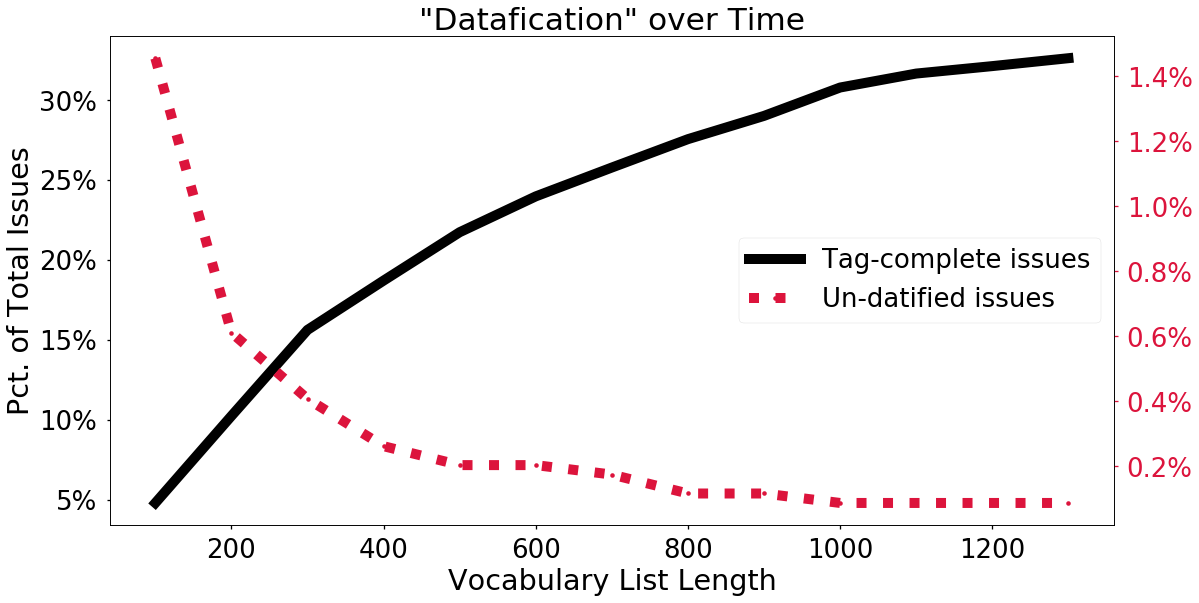

In [14]:
with sns.plotting_context('talk', rc={"lines.linewidth": 10}, font_scale=2):
    f,ax = plt.subplots(ncols=1, figsize=(18,9))
    tagged = ax.plot(np.arange(100,1400, 100),
             np.array([i['n_complete'] for i in case_study])/float(df_pred.shape[0]), 
               label='Tag-complete issues', c='k', marker='.')
    ax2 = ax.twinx()
    untag = ax2.plot(np.arange(100,1400, 100),
             np.array([i['n_empty'] for i in case_study])/float(df_pred.shape[0]),
             label = "Un-datified issues", marker='.', c='crimson', ls=':')

    lns = tagged + untag
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='center right')
    ax2.tick_params(axis='y', colors='crimson')

    ax.set_ylabel('Pct. of Total Issues')
    ax.set_xlabel('Vocabulary List Length')
    ax.set_title('"Datafication" over Time')
    # ax[0].legend(, loc=0)

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:.1%}'.format(x) for x in vals])

#     ax[1].plot(np.arange(100,1400, 100),
#              [i['FPR_2'][2].mean() for i in case_study], label=u'$F_2$-score', c='k',marker='.')
#     ax[1].plot(np.arange(100,1400, 100),
#              [i['FPR_2'][0].mean() for i in case_study], label='Precision', c='k', ls=':',marker='.')
#     ax[1].plot(np.arange(100,1400, 100),
#              [i['FPR_2'][1].mean() for i in case_study], label='Recall', c='k', ls='--',marker='.')

#     ax[1].plot(np.arange(100,1400, 100),
#              [i['hamming'] for i in case_study], label='Hamming', ls='-',marker='o', c='k', markerfacecolor='white')
#     ax[1].legend(loc='center right')
#     ax[1].set_ylabel('Score')
#     ax[1].set_xlabel('Vocabulary list length')
#     ax[1].set_title('Comparison Scores w.r.t. Standard Tagging')

#     plt.tight_layout()
#     plt.savefig('study.png')

# Analysis

Now that we have tags, what do we do with them?



# EDIT ME
- **MaxLikelihood Example Demo**
- **Something simpler?**



In [15]:
def get_relevant(df, col, topn=20):
    
    tags = [x[1][col].split(', ') for x in df.iterrows()]
    binner = MultiLabelBinarizer().fit(tags)
    vecs = binner.transform(tags)
    counts = vecs.sum(axis=0)
    relevant = [(binner.classes_[i], counts[i], vecs[:,i]) for i in counts.argsort()[-topn:][::-1]]
    return relevant

relevant = get_relevant(df_pred, 'Items', topn=20) +\
get_relevant(df_pred, 'Problem', topn=20) +\
get_relevant(df_pred, 'Solution', topn=20)
print('e.g. ...')
relevant[:10]

NameError: name 'MultiLabelBinarizer' is not defined

In [ ]:
# item_counts = Item_vecs.sum(axis=0)
# relevant = [(binner.classes_[i], item_counts[i], Item_vecs[:,i]) for i in item_counts.argsort()[-20:][::-1]]
event_df = pd.DataFrame(columns = [i[0] for i in relevant if i[0]!=u''], 
             data = np.array([i[2] for i in relevant if i[0]!=u'']).T)
# plt.barh()
event_df.head(10)

Now we want to get other information, say, the *time* a problem was submitted. 

In [ ]:
# og_data_loc = os.path.join(data_directory, 'Maintenance_All_Clean.xlsx')

og_data = pd.read_excel(human_tags_filepath,header=0)
og_data = og_data.loc[model.df.RawText.notnull()]
                        #[['DATE RECEIVED','Time Submitted']])
# og_data.set_index('DATE RECEIVED_Time Submitted', inplace=True)
og_data['DATE RECEIVED'] = pd.to_datetime(og_data['DATE RECEIVED'])
og_data.set_index('DATE RECEIVED', inplace=True)

# print og_data.iloc[1381]
og_data.head()

A helpful way to look at tag as a data-structure is as the same "bag of words" representation topic modeling uses

In [ ]:
og_data.head()
event_df.index = og_data.index
event_df.index = pd.to_datetime(event_df.index, errors='coerce')
event_df.iloc[2500:2505]

What issues are operators NOT solving that they could solve? How do we find this?

In [ ]:
week_df = event_df.resample('M').agg(sum).fillna(0)
# plt.hist(week_df['repair'].values, bins='auto')
# plt.hist(week_df['operator'].values, bins='auto')
with sns.plotting_context('talk'):
    sns.jointplot(week_df['repair'], week_df['operator'])
    print('Most operator tags occur:\n week of: ',week_df.operator.idxmax())
    plt.suptitle('No. Work-orders per Week', y=1.02)
    plt.tight_layout()

In [ ]:
# event_df[event_df.operator==1].sum().to_frame(name='operator_incidents').sort_values('operator_incidents', 
#                                                                                      ascending=False).iloc[:10]
print('Change in tags from previous week\n week of ',week_df.operator.idxmax())
week_df.diff().loc[week_df.operator.idxmax()].to_frame(name='tags').sort_values('tags',ascending=False).head(10)

 A lack of correlation between `repair` and `operator` is good (no blame-game). 
 
 One week seems to spike, perhaps related to replacing coolant?

In [ ]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.

adapted from:
    'Martijn Vermaat' 14 Feb 2016
    'martijn@vermaat.name'
    'https://github.com/martijnvermaat/calmap'
"""
from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion

_pandas_18 = StrictVersion(pd.__version__) >= StrictVersion('0.18')


def yearplot(data, year=None, how='sum', vmin=None, vmax=None, cmap='Reds',
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,
             **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    Examples
    --------
    By default, `yearplot` plots the first year and sums the values per day:
    .. plot::
        :context: close-figs
        calmap.yearplot(events)
    We can choose which year is plotted with the `year` keyword argment:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, year=2015)
    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)
    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])
    """
    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)

    # Min and max per day.
    if vmin is None:
        vmin = by_day.min().min()
    if vmax is None:
        vmax = by_day.max().max()

    if ax is None:
        ax = plt.gca()

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
#         linecolor = ax.get_axis_bgcolor()
        linecolor = ax.get_facecolor()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'

    # Filter on year.
    by_day = by_day[by_day.index.year==year]

    # Add missing days.

    plot_data = by_day.transpose().fillna(0)

    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect('equal')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2::monthticks]

    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []
    elif isinstance(dayticks, int):
        dayticks = range(len(daylabels))[dayticks // 2::dayticks]
    ax.set_xlabel('')
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center')
    
    ax.set_xticks([pd.Timestamp('{}/15/{}'.format(i, year)).week-1.5 for i in range(1,13)])
    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([by_day.columns.shape[0] - i - .5  for i in range(by_day.columns.shape[0])])
    ax.set_yticklabels(by_day.columns[::-1], rotation='horizontal',
                       va='center')

    return ax

def calendarplot(data, how='sum', yearlabels=True, yearascending=True, yearlabel_kws=None,
                 subplot_kws=None, gridspec_kws=None, fig_kws=None, **kwargs):
    """
    Plot a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    yearlabels : bool
       Whether or not to draw the year for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `add_subplot` call used to
        create each subplot.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `figure` call.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.
    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.
    Examples
    --------
    With `calendarplot` we can plot several years in one figure:
    .. plot::
        :context: close-figs
        calmap.calendarplot(events)
    """
    yearlabel_kws = yearlabel_kws or {}
    subplot_kws = subplot_kws or {}
    gridspec_kws = gridspec_kws or {}
    fig_kws = fig_kws or {}

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,
                             subplot_kw=subplot_kws,
                             gridspec_kw=gridspec_kws, **fig_kws)
    axes = axes.T[0]

    # We explicitely resample by day only once. This is an optimization.
    if how is None:
        by_day = data
    else:
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)

    ylabel_kws = dict(
        fontsize=32,
        color=kwargs.get('fillcolor', 'xkcd:wheat'),
        fontweight='bold',
        fontname='Arial',
        ha='center')
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    # Make the axes look good.
    plt.tight_layout()

    return fig, axes

Let's pick a few interesting items, and see how often they come up as a problem/solution: 

In [ ]:
# plt.figure
with sns.plotting_context('talk', font_scale=2):
    calendarplot(event_df[['hydraulic',
                           'leak',
                           'spindle',
                           'accumulator',
                           'coolant'
                           ]][event_df.index.year==2016],
                 how='sum', fig_kws={'figsize':(20,12)});
    plt.title('Relative Tag Occurrence Density by Month')
# yearplot(event_df[['hydraulic', 'spindle','accumulator', 'operator']], how='sum', fig_kws={'figsize':(12,8)})
# og_data[event_df.index.isnull()]

- hydraulic leaks increase in the summer, very low in spring? 
- Coolant requests at semi-regular intervals? 

## Beginning of Prognostics

We need to approximate the idea of "machine failure" as opposed to "machine maintenance" 
>compare to "patient care" vs. "patient death". 

One way is to only find items occuring with "broken" **AND** "replace". While not 100% accurate, it's definitely a quick and dirty way to estimate the failure rate.  

In [ ]:
weekly_replace = event_df[(event_df['broken']==1) & (event_df['replace']==1)].resample('W').agg(sum).fillna(0)
with sns.plotting_context('talk', font_scale=2):
    calendarplot(weekly_replace[['hydraulic',
                                 'motor',
                                 'spindle',
                                 'accumulator',
                                 'valve'
                                ]][weekly_replace.index.year==2016], 
                 fig_kws={'figsize':(20,12)});
    plt.title('Tag Co-occurrence with "broken" and "replace", by Month')

In [ ]:
from scipy.stats import norm, expon
def get_fail_iat(event_df, tag):
    fail_time_valve = event_df[(event_df['broken']==1) & (event_df['replace']==1) & (event_df[tag]==1)]
    fail_time_valve.reset_index(inplace=True)
    iat_valve = fail_time_valve['DATE RECEIVED']-fail_time_valve.shift()['DATE RECEIVED']
    return iat_valve
with sns.plotting_context('talk'):
    plt.figure(figsize=(12,8))
    plt.hist((get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).values[1:], label='motor',
                                                                 normed=True)
    plt.title('Failure Interarrival Time Distributions\n (with parametrized comparison)')
    plt.xlabel('no. days')

    plt.hist((get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).values[1:], label='spindle', 
                                                                   alpha=.7, normed=True, bins='auto')

    print('expected interarrival time')
    print('spindle fail:\t{:.2f} days'.format((get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).mean()))
    plt.plot(range(120), expon(scale=(get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).mean()).pdf(np.arange(120)),
            color='orange')

    print('motor fail:\t{:.2f} days'.format((get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).mean()))
    plt.plot(range(120), expon(scale=(get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).mean()).pdf(np.arange(120)),
            color='dodgerblue')
    plt.grid(b=False)
    plt.legend()

    plt.text(40, 0.03, r'$\delta_f(\mathrm{spindle})\sim\mathrm{Exp}(26.1)$',
             fontsize=12)
    plt.text(40, 0.02, r'$\delta_f(\mathrm{motor})\sim\mathrm{Exp}(17.9)$',
             fontsize=12)

# Taxonomy Generation

It would be great if we had organized all of these tags, determining which ones are more general or specific. 

It would be even better if we had a starting point to do that, done for us. 

### Graph Theory I

Retrieving those same binary vectors for the top Items, lets call them $\bf{B}$. What we want is an idea of how many times particular tags happen together. 

Luckily, this is $B^{T}B$ 

In [ ]:
itm_relevant = get_relevant(df_pred, 'Items', topn=700)
itm_event = pd.DataFrame(columns = [i[0] for i in itm_relevant if i[0]!=u''], 
             data = np.array([i[2] for i in itm_relevant if i[0]!=u'']).T)



In [ ]:
coocc = itm_event.T.dot(itm_event)
occ = np.diagonal(np.copy(coocc))

np.fill_diagonal(coocc.values, 0)
coocc.head()


Actually, $B^{T}B$ contains the overall occurrence count in it's diagonal. What we are actually using is $B^{T}B-\text{diag}(B^{T}B)$, which is called an *adjacency* graph. 

### Graph Theory II

One way to analyse this is using some notion of **node similarity**. There are a few different ways of measuring the similarity of tags, but one straight-forward one is the ever-popular *cosine similarity*. In the context of co-occurnce graphs, we can caclulate this as 

$$ \frac{n_{x,y}}{\sqrt{n_x}\sqrt{n_y}} $$

Where $n_x$, $n_y$, and $n_{x,y}$ are the number of "issues" or documents tagged with the tag, $x$, $y$, or $x\cup y$, respectively. This makes for a nice edge weigting on our cooccurrence graph. 

In [ ]:
dist_mat = coocc/np.dot(np.sqrt(occ).T, np.sqrt(occ))

dist_mat.head()

However, this is a symmetric measure, so it doesnt't help us in creating any kind of taxonomy. That's where centrality comes in. 

### Graph Theory III

Centrality is a way of rank-ordering nodes according to their "importance" in the graph. There are many ways to formalize this idea, and Google built its business around **PageRank**, a remarkably robust centrality measure. 

For example, we have: 

    A.  Betweenness centrality, 
    B.  Closeness centrality, 
    C.  Eigenvector centrality, 
    D.  Degree centrality, 
    E.  Harmonic Centrality and 
    F.  Katz centrality 
of the same graph. (PageRank is related to eigen-centrality)

Now we can combine what we know to make a taxonomy!

![Tapiocozzo, https://commons.wikimedia.org/wiki/File:6_centrality_measures.png](6_centrality_measures.png)

In [ ]:
import networkx as nx

G = nx.from_numpy_matrix(dist_mat.values)
G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))

In [ ]:
# cent = pd.Series(nx.closeness_centrality(G, distance='weight'))
# cent = pd.Series(nx.betweenness_centrality(G))
# cent = pd.Series(nx.eigenvector_centrality(G))
cent = pd.Series(nx.pagerank(G))

In [ ]:
cent.sort_values(ascending=False).iloc[:10].index.values
# cent

### Graph Theory IV

The **Heymann** algorithm [Heymann 2006] is an efficient algorithm that converts a set of these "tags" into a taxonomy via "annotation frequencies". 

1. List Tags **in order** of generality, which we measure by proxy via **centrality**. 
2. **For** each tag in the ordered list (starting with the "most general" node as a root):
    1. **Insert** it as a node
    2. Find the node, already in the taxonomy, **most similar** to it
    3. **If** this similarity is above some **threshold**, add an edge from that node to this on
    4. Else, leave this node as a top-level tag \*
3. **Remove** any "isolates", or nodes that have no descendants in the taxonomy. 

As a consequence of the similarity threshold, this particular algorithm **removes** any unnecessary and/or **irrelevant tags**. 

\*This is a slight modification, which allows for multiple top-level concepts in the taxonomy. 

### Heymann Algorithm 
Created originally for website orgianization and analysis, it's a graph-theoretic method that combines:
- tag **centrality** - orders nodes by how *general* they are
- tag **similarity** - groups nodes by how *similar* they are 
For exaple, using *cosine similarity* and *PageRank* Score:

In [ ]:
def heymann_taxonomy(dist_mat, cent_prog='pr', tau=5e-4, 
                     dynamic=False, dotfile=None, verbose=False):
    """
    dist_mat: dataframe containing similarity matrix, indexed and named by tags
    cent_prog: algorithm to use in calculating node centrality
        pr: PageRank
        eig: eigencentrality
        btw: betweenness
        cls: closeness
    tau: similarity threshold for retaining a node
    dynamic: re-calculate centrality after adding every tag
    write_dot: fname or None, where to save a .dot, if any. 
    verbose: print some stuff
    """
#     tau = 5e-4
    cent_dict = {
        'pr': nx.pagerank,
        'eig': nx.eigenvector_centrality,
        'btw': nx.betweenness_centrality,
        'cls': nx.closeness_centrality
    }
    
    # Create the co-occurence graph, G
    G = nx.from_numpy_matrix(dist_mat.values)
    G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))
    
    # Calculate the centrality of nodes in G
    cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
    root = cent.index[0]
    
    # Init the taxonomy D (DAG)
    D = nx.DiGraph()
    D.add_node(root)

    for n in tqdm_notebook(range(dist_mat.shape[0])):
        
        # Pick the most central node in G, and the node in D most similar to it
        tag = cent.index[0]
        neighbor_sim =  {k: dist_mat.loc[tag,k] for k in D.nodes()}
        parent = max(neighbor_sim, key=lambda key: neighbor_sim[key])
        
        if neighbor_sim[parent] > tau:
            # above threshold--> direct child
            D.add_node(tag)
            D.add_edge(parent, tag)
        else:
    #         D.add_edge(root, descendant)  # do not enforce single taxonomy
            # New "top-level" tag
            D.add_node(tag)
            pass
        
        if dynamic:
            # recalculate node centralities after removing each <tag>
            # EXPENSIVE.
            G.remove_node(tag)
            cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
        else:
            cent.drop(tag, inplace=True)
    
    if verbose:
        print(root) # most "general" topic
        print(nx.isolates(D)) # child-less nodes (i.e. central AND dissimilar)
    
    
    D.remove_nodes_from(nx.isolates(D))  # not useful for taxonomy
    
    if dotfile is not None:
        from networkx.drawing.nx_pydot import graphviz_layout, write_dot
        D.graph['graph']={'rankdir':'LR', 'splines':'true', 
                          'ranksep':'4'}
        write_dot(D, dotfile)
    
    return D

D = heymann_taxonomy(dist_mat, 
                     cent_prog='pr' # dynamic=True,
#                      dotfile='tax.dot'
                    )

In [ ]:
# from networkx.drawing.nx_pydot import graphviz_layout, write_dot
# write_dot(D, 'tax.dot')
# !dot -Tpng tax.dot >tax.png

In [ ]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'unit')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'unit'), outfile)

In [ ]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1500 - margin.right - margin.left,
    height = 1200 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

In [ ]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [ ]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
f2(w=1500,h=1200)

# Questions/Comments?

In [292]:
import graph_tool.all as gta
import graph_tool as gt

In [294]:
from nx2gt import nx2gt

g = nx2gt(G)
d = nx2gt(D)

In [526]:
d.save('gs_tax.gt')
g.save('gs_graph.gt')


In [295]:
pos = gta.fruchterman_reingold_layout(d, r=10., )
gta.graph_draw(g, pos=pos, output="graph.png")

ValueError: Received property map for graph <Graph object, undirected, with 492 vertices and 11339 edges at 0x7f917f01def0> (base: <Graph object, undirected, with 492 vertices and 11339 edges at 0x7f917f01def0>), expected: <Graph object, directed, with 267 vertices and 263 edges at 0x7f917f008860> (base: <Graph object, directed, with 267 vertices and 263 edges at 0x7f917f008860>)

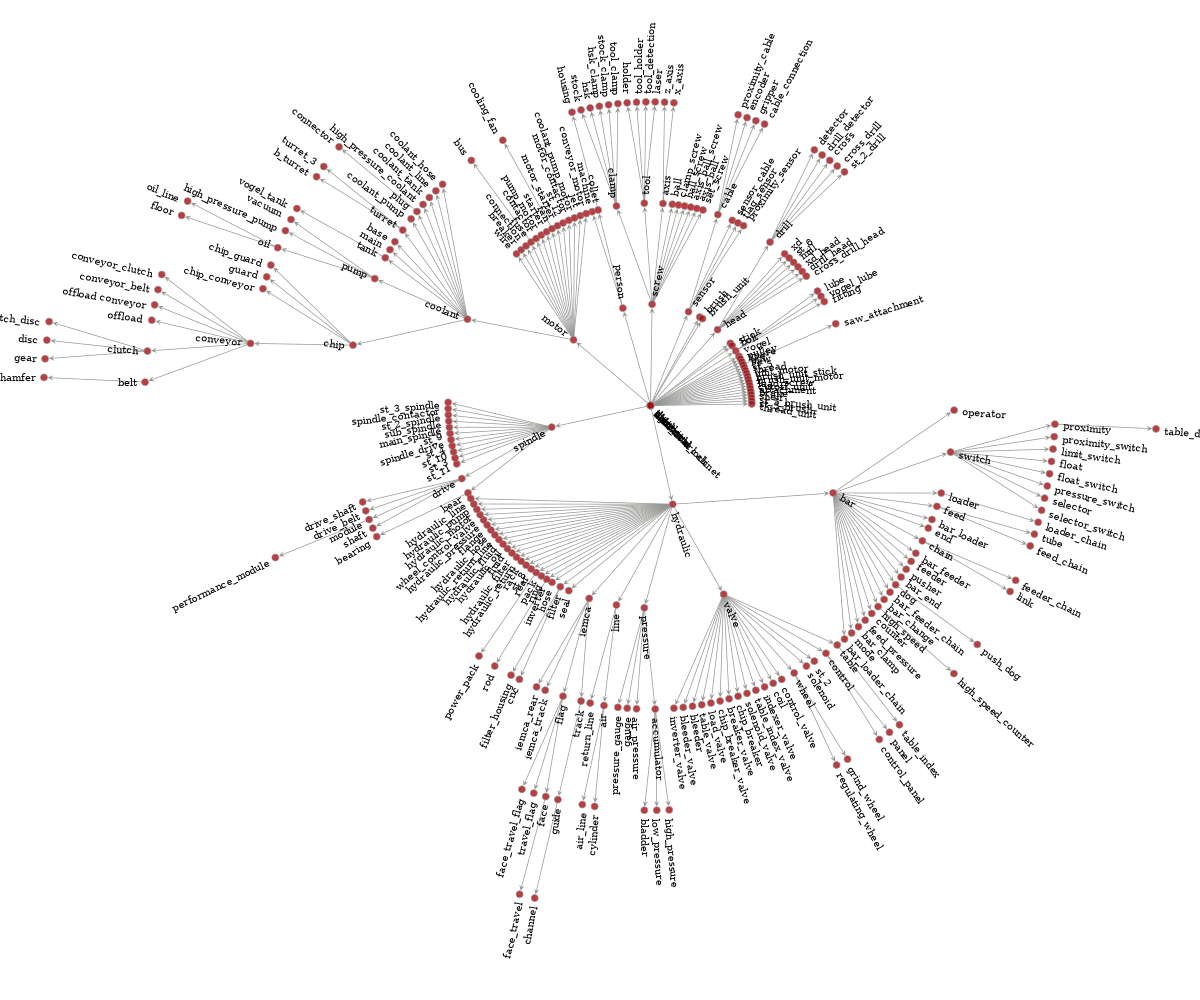

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f917f008860, at 0x7f917edfc668>

In [387]:
# g.edges().next().target()
pos = gta.radial_tree_layout(d, root=0, 
#                              rel_order_leaf=True, 
                             weighted=True
                            )
# pos = gta.fruchterman_reingold_layout(d)
gta.graph_draw(d, 
               pos=pos, 
               output_size=(1200,1000), 
               inline=True,
               vertex_text=d.vertex_properties["id"],
               vertex_text_position='centered',
               vertex_font_size=10, 
               vertex_size=7,
               edge_color='xkcd:grey')

In [327]:
state = gta.minimize_nested_blockmodel_dl(d)

In [329]:
# state.draw(output="hsbm-fit.png")
state.print_summary()
# g.vertex_properties['id']

l: 0, N: 267, B: 1
l: 1, N: 1, B: 1


In [359]:
g.vertex_properties['id'][g.vertices().next()]
# g.list_properties()
gta.find_vertex(g, g.vertex_properties['id'], 'unit')

[<Vertex object with index '0' at 0x7f91647ab210>]

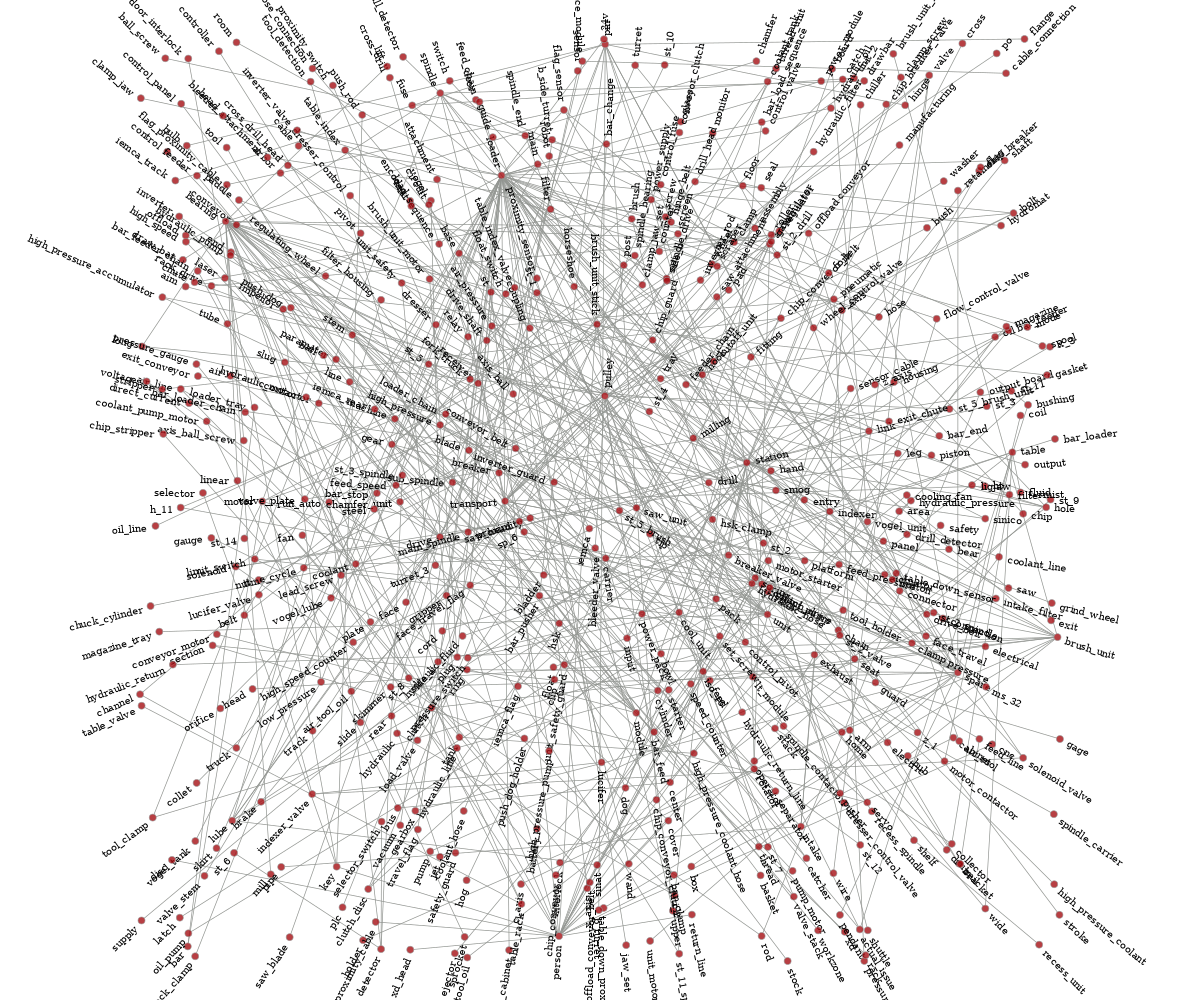

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f917f01def0, at 0x7f9175018588>

In [406]:
pos = gta.random_layout(g)
# pos = gta.fruchterman_reingold_layout(d)
gta.graph_draw(g, 
               pos=pos, 
               output_size=(1200,1000), 
               inline=True,
               vertex_text=g.vertex_properties["id"],
               vertex_text_position='centered',
               vertex_font_size=10, 
               vertex_size=7,
               edge_color='xkcd:grey')

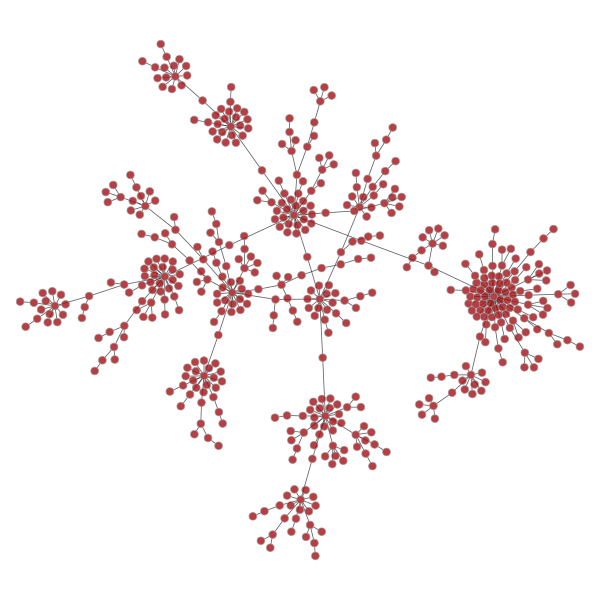

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f917f01def0, at 0x7f917f9ecfd0>

In [408]:
tree = gta.min_spanning_tree(g, weights=g.edge_properties['weight'])
g.set_edge_filter(tree)
gta.graph_draw(g)

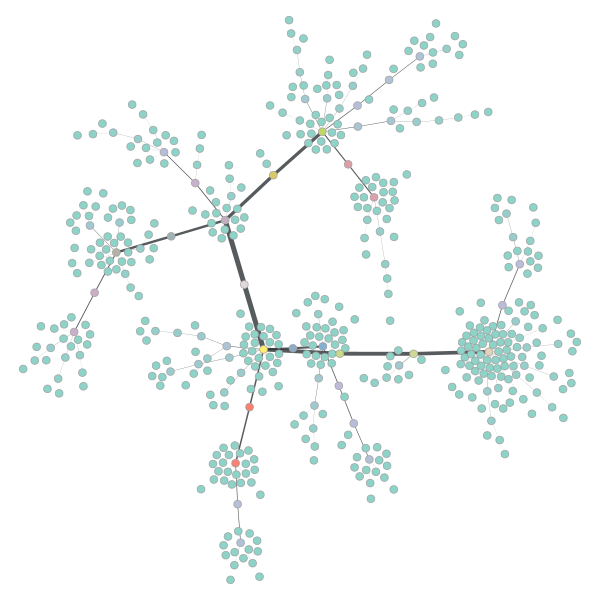

In [409]:
bv, be = gta.betweenness(g)
be.a /= be.a.max() / 5
pos = gta.graph_draw(g, vertex_fill_color=bv, edge_pen_width=be)

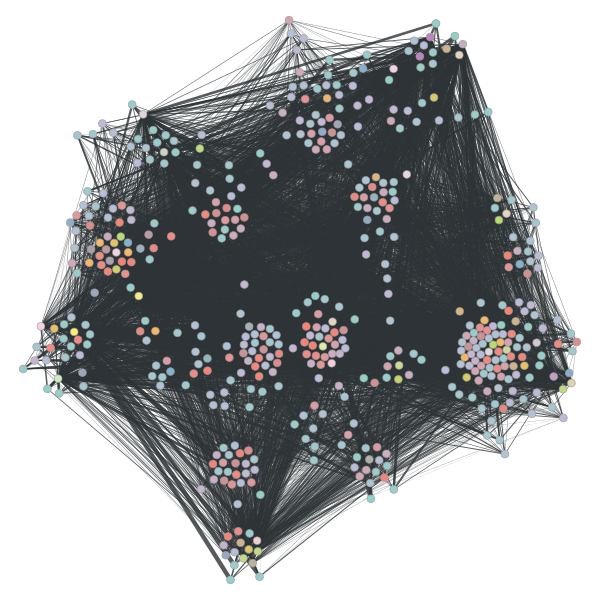

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f917f01def0, at 0x7f91843ebf28>

In [415]:
g.set_edge_filter(None)
bv, be = gta.betweenness(g)
prv = gta.pagerank(g)
be.a /= be.a.max() / 5
gta.graph_draw(g, pos=pos, vertex_fill_color=prv, edge_pen_width=be)


In [426]:
from graph_tool.all import *
state = minimize_nested_blockmodel_dl(g, deg_corr=True)
state.draw()

AttributeError: module 'graph_tool.draw' has no attribute 'draw_hierarchy'

In [427]:
graph_tool.draw.interactive_window()

AttributeError: module 'graph_tool.draw' has no attribute 'interactive_window'

# Notes/Extras

### How well did we do at automating the job of Tagging Issues?

In order to somehow measure our success, we need something to compare with. 

Thankfully, some hard-working engineers have gone through and manually tagged over 1200 maintenance issues **by hand**. 

We can use these tags as the "gold standard" tags, with which to compare our automated keyword-->tag mapping. 

In [ ]:
human_tags_filepath = os.path.join(data_directory, 'human_tag', 'tag_data2.xlsx')

# df_tag = pd.read_excel(human_tags_filepath, header=0, encoding=sys.getfilesystemencoding(), 
#                    names=['Description','Resolution','p_Item','p_Action','s_Action','s_Item'], usecols=5)



human_tags = [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
              for issue in df_tag[mask].iterrows()]

recog_tags =  [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
              for issue in df_pred.loc[mask, ['Items','Problem','Solution']].iterrows()]

# print(human_tags[0])


multi_bin =  MultiLabelBinarizer().fit(human_tags + recog_tags)
Y_true = multi_bin.transform(human_tags)
# print(Y_true[0].sum())

Y_train = multi_bin.transform(recog_tags)

#### But how will we measure this? 

One way is straight-forward and easy to compute...the accuracy. The **accuracy score** measures, on average, how many predicted outputs match the true outputs perfectly:

\begin{equation}
S_A = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}(T_i = P_i)
\end{equation}

**A better alternative :**

This is an *overly-harsh metric* for the performance of multilabel classification, since it ignores *how close* we got to the correct output in each case. The **hamming score** is a more forgiving and/or useful metric:
$$S_H = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|T_i \cup P_i|}$$
Note that the closely related **hamming loss** is similar to a distance metric, which unlike the others here is *better when low*.

#### Interpretability, please: 
Finally, we can use the slightly more intuitive **precision**, **recall**, and their harmonic mean **$F_1$-score**. As put by Scikit-Learn: 
> Intuitively, *precision* is the ability of the classifier *not to label as positive a sample that is negative*, and *recall* is the ability of the classifier *to find all the positive samples*.

Then, we can get some sort of combination that balances the two, embodied by $F_1$. Or, put formally:


$$Pr = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|P_i|} \qquad Re = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|T_i|}$$
$$F_1 = \frac{1}{n}\sum_{i=1}^{n} \frac{2Pr_i Re_i}{Pr_i+Re_i}$$

If we want to model some difference between our **importance** of recall vs. precision, the generalized $F$-score is defined as:

$$F_{\beta} = \frac{1}{n}\sum_{i=1}^{n} (1+\beta^2)\frac{Pr_i Re_i}{\beta^2 Pr_i+Re_i}$$

> $F_{\beta}$  "measures the effectiveness of retrieval with respect to a user who attaches $\beta$ times as much importance to recall as precision".

In our case, Since we do not really trust that the original tags given by humans were all-inclusive (i.e. they might have left out tags below some un-known relevance threshold determined by their attention [read: boredom] level), we want to place more importance on recall in our $F$-measure. We'll use the commonly-applied $F_2$

In [512]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
from scipy.stats import hmean  # harmonic mean

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def f_score(y_true, y_pred, beta=1.):
    '''
    Compute the Precision, Recall, and F-beta Score for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    fsc_list = []
    pre_list = []
    rec_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_p, tmp_r, tmp_f = 1, 1, 1
        elif len(set_true.intersection(set_pred)) ==0:
            tmp_p = 0
            tmp_r = 0
            tmp_f = 0
        else:
            tmp_p = len(set_true.intersection(set_pred))/\
                    float( len(set_pred) ) 
            tmp_r = len(set_true.intersection(set_pred))/\
                    float( len(set_true) )
            try:
                tmp_f = ((1.+beta**2)*tmp_p*tmp_r)/((beta**2)*tmp_p + tmp_r)
            except ValueError:
                print(tmp_p, tmp_r)
                raise
        #print('tmp_a: {0}'.format(tmp_a))
        pre_list.append(tmp_p)
        rec_list.append(tmp_r)
        fsc_list.append(tmp_f)
    return np.array(pre_list), np.array(rec_list), np.array(fsc_list)

def score_report(Y_true, Y_train, beta=1):
   
    print(f'Accuracy Score: \t {accuracy_score(Y_true, Y_train):.2%}'+\
          f'\nHamming Score: \t {hamming_score(Y_true, Y_train):.2%}'+\
          f'\nHamming Loss: \t {hamming_loss(Y_true, Y_train):.2e}')

    print('\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF{beta} Score: \t {:.2%}'.format(
        *[np.mean(i) for i in f_score(Y_true, Y_train, beta=beta)], beta=beta
    ))

print('---Automatic Keyword Tagging (TF-IDF+human) ---')
score_report(Y_true, Y_train, beta=2.)


---Automatic Keyword Tagging (TF-IDF+human) ---
Accuracy Score: 	 0.66%
Hamming Score: 	 25.00%
Hamming Loss: 	 5.07e-03

Precision: 	 30.22%
Recall: 	 44.71%
F2.0 Score: 	 38.59%


## Using Machine Learning (SVM + Word2Vec)
### Benchmarking the auto-tagger

### Is there another way? 

Now, it's important to note that all of the above was done **only** with a list of categorized keywords (i.e. some mapping from token-space to tag-space), and creating that mapping did not at all depend upon some human having tagged *individual issues* already...we were just using those tagged issues as a scoring/benchmark tool. 

If we approach this as a classification problem, assuming these tagged issues *do exist*, we might attempt to train a classifier to predict the set of tags appropriate for given **raw-english** input.

#### Let's try this: 
- first a mapping from token-space to some useful vector-space (could be tf-idf, maybe a topic model, but here we will use the shiny new **Word2Vec** semantic embedding vectors of our corpus, courtesy of Google+Textacy/Spacy). 
- Then we will train a **classifier** to exactly match the **Multilabel** output, represented by the individual human-tagged issues. 

Support-vector-machines work amazingly well on text embedding classification jobs, so let's use a linear SVC trained using stochasic gradient descent (SGD) via sklearn. We should also minimize overfitting with this hugely dimensional job, so we'll regularize with an elasticnet penalty (L1+L2).  

![svm_pipe.png](svm_pipe.png)

```python 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

X_train = corpus.vectors[mask]
clf = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ), n_jobs=3  # 3-cores for the one-vs-all 
                         )
clf.fit(X_train, Y_true)
Y_train_w2v = clf.predict(X_train)
```

In [156]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import warnings

X_train = model.corpus.vectors[mask]
clf = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ), n_jobs=-1  # cores for the one-vs-all 
                         )
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf.fit(X_train, Y_true);
Y_train_w2v = clf.predict(X_train)

In [224]:
print('---W2V Embeddings with SVC (OneVsRest, SGD)---')
score_report(Y_true, Y_train_w2v, beta=2)

---W2V Embeddings with SVC (OneVsRest, SGD)---
Accuracy Score: 	 6.47%
Hamming Score: 	 17.04%
Hamming Loss: 	 2.87e-03

Precision: 	 35.60%
Recall: 	 18.00%
F2 Score: 	 18.90%


In [159]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import warnings
from sklearn.externals import joblib

grid_search_fname =  'GS_grid_search_w2vSGD.pkl'

if not os.path.isfile(grid_search_fname):
    parameters = {
        'estimator__alpha': (1e-3, 1e-4, 1e-5),
        'estimator__penalty': ('l1', 'l2', 'elasticnet'),
        'estimator__n_iter': (1, 5, 10),
        'estimator__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    }

    grid_search = GridSearchCV(clf, parameters, verbose=1, n_jobs=-1)

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    t0 = time()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_true)
    print("done in %0.3fs" % (time() - t0))
    print()
    joblib.dump(grid_search, grid_search_fname) 

else:
    grid_search = joblib.load(grid_search_fname)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'estimator__alpha': (0.001, 0.0001, 1e-05),
 'estimator__loss': ('hinge',
                     'log',
                     'modified_huber',
                     'squared_hinge',
                     'perceptron'),
 'estimator__n_iter': (1, 5, 10),
 'estimator__penalty': ('l1', 'l2', 'elasticnet')}
Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 18.1min finished


done in 1090.522s

Best score: 0.033
Best parameters set:
	estimator__alpha: 0.001
	estimator__loss: 'log'
	estimator__n_iter: 10
	estimator__penalty: 'l2'


In [225]:
Y_train_cv = grid_search.predict(X_train)
print('---W2V Embeddings with SVC (OneVsRest, SGD)---')
score_report(Y_true, Y_train_cv, beta=2)

---W2V Embeddings with Grid-search SVC---
Accuracy Score: 	 7.68%
Hamming Score: 	 17.43%
Hamming Loss: 	 2.86e-03

Precision: 	 34.57%
Recall: 	 18.32%
F2 Score: 	 19.15%


In [162]:
# from __future__ import print_function
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display

def compare_by_issue(iss):
    print('Issue No. ',iss)
    print(df_pred[mask]['RawText'].iloc[iss])
    print('\nHuman-tagged \"True\" Keyworks/Tags: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_true)[iss]))))

    print('\nTF-IDF rank Human-classified keywords: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_train)[iss]))))
    print('Precision: \t {:.2%}\nRecall: \t {:.2%}\nF2 Score: \t {:.2%}'.format(
        *[i[iss] for i in f_score(Y_true, Y_train, beta=2.)]
    ))
    print('\nWord2Vec + SVM Multilabel Classifier: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_train_w2v)[iss]))))
    print('Precision: \t {:.2%}\nRecall: \t {:.2%}\nF2 Score: \t {:.2%}'.format(
        *[i[iss] for i in f_score(Y_true, Y_train_w2v, beta=2.)]
    ))
# compare_by_issue(0)

In [201]:
svm_study = []
for n_vocab in tqdm_notebook(range(30)):
    res = {}
    
#     res['clf'] = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
#                                             penalty='elasticnet',   # L1 + L2 regularized
#                                             n_iter=80,
#                                                 alpha=0.001
#                                             ), n_jobs=-1  # all cores for the one-vs-all 
#                               )
    res['clf'] = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                            penalty='l2',   # L2 regularized
                                            n_iter=10,
                                            alpha=0.001,
                                            loss='log'
                                            ), n_jobs=-1  # all cores for the one-vs-all 
                                    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res['clf'].fit(X_train, Y_true)
    Y_train_w2v = res['clf'].predict(X_train)
    
    res['accuracy'] = accuracy_score(Y_true, Y_train_w2v)
    res['hamming'] = hamming_score(Y_true, Y_train_w2v)
    res['FPR_2'] = f_score(Y_true, Y_train_w2v, beta=2)
    
    svm_study += [res]

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

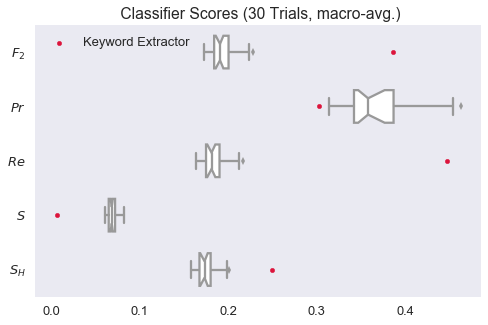

In [447]:
keyword_scores = [np.mean(i) for i in f_score(Y_true, Y_train, beta=2)]
keyword_scores += [hamming_score(Y_true, Y_train)]
keyword_scores += [accuracy_score(Y_true, Y_train)]
keyword_scores = np.array(keyword_scores)[[2,0,1,4, 3]]
# keyword_errors = [iqr(i) for i in f_score(Y_true, Y_train_w2v, beta=2)]
# keyword_errors += [0.]
# keyword_errors = np.array(keyword_errors)[[2,0,1,3]]

# plt.errorbar(x, y, yerr=e, fmt='o')                  
with sns.plotting_context('talk'):
    sns.set_style('dark')
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_svm, orient='h', width=.6, color='white', notch=True, bootstrap=10000)
    plt.scatter(keyword_scores, [0,1,2,3,4], c='crimson', marker='.', s=80, label='Keyword Extractor', zorder=10)
    # plt.errorbar(keyword_scores, [0,1,2,3], xerr=keyword_errors, fmt='o')  
    plt.legend(loc=0)
    plt.title(' Classifier Scores (30 Trials, macro-avg.)')
# plt.boxplot()

In [202]:
from scipy.stats import iqr

df_svm = pd.DataFrame.from_dict(data={
                            u'$S$' : np.array([i['accuracy'] for i in svm_study]),
                            u'$Pr$': np.array([i['FPR_2'][0].mean() for i in svm_study]),
                            u'$Re$': np.array([i['FPR_2'][1].mean() for i in svm_study]),
                            u'$F_2$':np.array([i['FPR_2'][2].mean() for i in svm_study]),
                            u'$S_H$':np.array([i['hamming'] for i in svm_study])
                        }
                     )
# sns.distplot(df_svm[u'$S_H$'])
def IQR(a):
    return np.subtract(*np.percentile(a, [75, 25]))

pd.DataFrame({'Median':df_svm.agg('median'), 'IQR':df_svm.agg(IQR)})


,IQR,Median
$F_2$,0.016281,0.190900
$Pr$,0.044721,0.358264
$Re$,0.015241,0.181343
$S$,0.007186,0.068546
$S_H$,0.012621,0.173427


Wow, that's pretty fantastic, considering the task we've set before it! Better performance, at least on a per-metric level, than our automated keyword-tagger in every way! 

Still, note that the precision is almost 80%...this may or may not be a model we want to actually use early on, given that we may or may not trust our engineers' tagging job. Assuming We 100% trust the keyword flagger when it recognizes a word, the precision of that one is actually 100%, and any discrepancy is on the part of *the original tags*. 

Another way to look at it is our keyword tagger is being really nit-picky and overly-accurate, which precision is punishing. Our classifier, on the other hand, is being trained *to tag like the humans*. 

Let's dig in a bit.. To get a more fine-grained idea of what's going on, we can also look at the Pr/Re/F scores on an individual-issue level to get a better idea of the performance of each model. 

In [226]:
interact(compare_by_issue, iss=widgets.BoundedIntText(
                    value=0,
                    min=0,
                    max=3437,
                    description='Pick an Issue No.:',
                    step=1
                    )
               );
# display(w)

interactive(children=(BoundedIntText(value=0, description='Pick an Issue No.:', max=3437), Output()), _dom_classes=('widget-interact',))